In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считаем данные


In [2]:
df = pd.read_csv('car_price.csv')


df.isnull().sum()


car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

В датасете нет пропущенных значений.

Стоимость машины не зависит от конкретного названия, но может зависить от марки, поэтому оставим только марки машин

In [3]:
df["manufacturer"] = ""
df["manufacturer"] = [x.split(" ")[0] for x in df["CarName"]] 
df.drop("CarName", axis=1, inplace=True)

car_ID - это правда индекс? Посмотрим на количество сущностей

In [4]:
df.count()


car_ID              205
symboling           205
fueltype            205
aspiration          205
doornumber          205
carbody             205
drivewheel          205
enginelocation      205
wheelbase           205
carlength           205
carwidth            205
carheight           205
curbweight          205
enginetype          205
cylindernumber      205
enginesize          205
fuelsystem          205
boreratio           205
stroke              205
compressionratio    205
horsepower          205
peakrpm             205
citympg             205
highwaympg          205
price               205
manufacturer        205
dtype: int64

In [5]:
len(df["car_ID"].unique())


205

Действительно, car_ID - это просто индекс. Его можно убрать, а не рассматриватьт как порядковый признак

In [6]:
df.drop("car_ID", axis=1, inplace=True)

Заметим, что количество цилиндров и дверей описано строками:

In [7]:
list(df["cylindernumber"].unique())


['four', 'six', 'five', 'three', 'twelve', 'two', 'eight']

In [8]:
list(df["doornumber"].unique())

['two', 'four']

Заменим на числа:

In [9]:
df["cylindernumber"].replace(["four", "six", "five", "three", "twelve", "two", "eight"], [4, 6, 5, 3, 12, 2, 8], inplace=True)
df["doornumber"].replace(["two", "four"], [2, 4], inplace=True)

Посмотрим на признак fueltype:

In [10]:
df.fueltype.unique()

array(['gas', 'diesel'], dtype=object)

Преобразуем его:

In [11]:
#df = df.join(pd.get_dummies([ x + " fuel" for x in df.fueltype]))
df["fueltype"] = df["fueltype"].apply(lambda x: 1 if x=="gas" else 0)

Теперь признак aspiration:

In [12]:
df.aspiration.unique()

array(['std', 'turbo'], dtype=object)

In [13]:
#df = df.join(pd.get_dummies([ x + " aspiration" for x in df.aspiration]))
df["aspiration"] = df["aspiration"].apply(lambda x: 1 if x=="turbo" else 0)

Есть ли зависимость между типом топлива, типом подачи воздуха в двигатель и компрессией, количеством цилиндров?

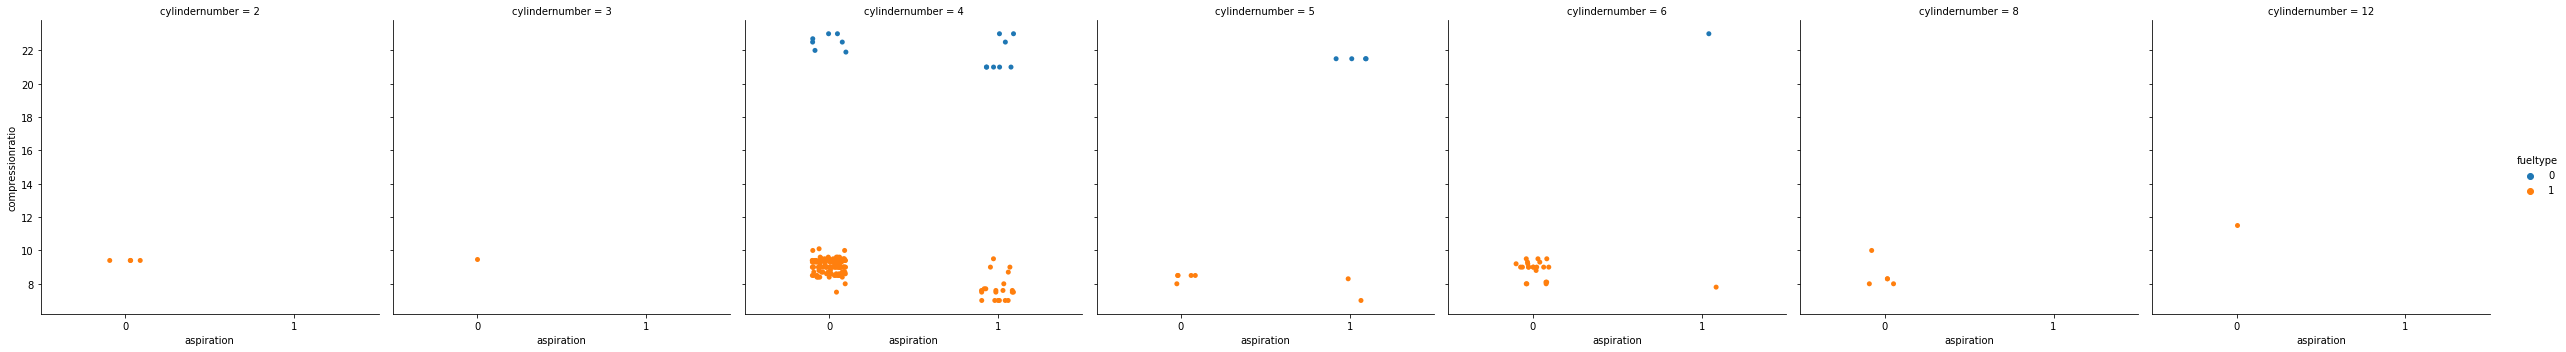

In [14]:
sns.catplot(x='aspiration', y='compressionratio', data=df, hue='fueltype', col="cylindernumber");



Дизельные моторые не зависимо от способа подачи воздуха и количества цилиндров имеют более высокую степерь сжатия.
Двухцилиндровые и трехцилиндровые авто кажутся экзотическими и работующими только на бензине. 12-цилиндровые - тоже. Очень ли они дорогие? 

<AxesSubplot:xlabel='cylindernumber', ylabel='price'>

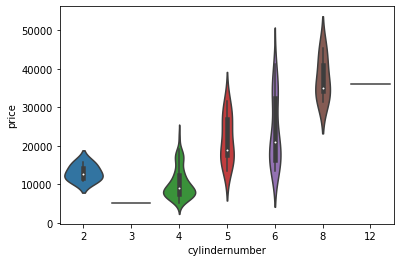

In [15]:
sns.violinplot(data=df, x="cylindernumber", y="price")

Кажется, что с увеличением количества цилиндров двигателя увеличивается и стоимость авто. Как соотносятся объем двигателя и количество цилиндров?

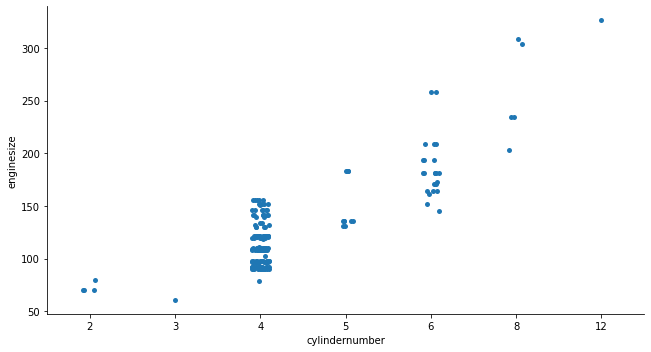

In [16]:
sns.catplot(x='cylindernumber', y='enginesize', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

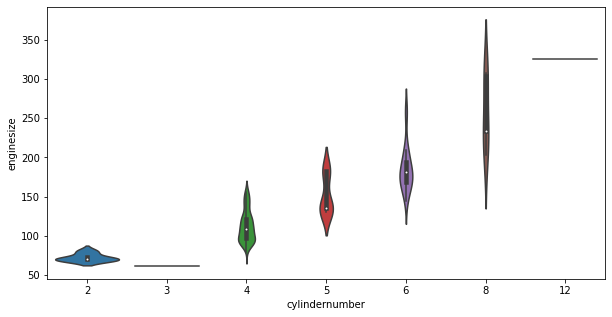

In [17]:
sns.violinplot(data=df, x="cylindernumber", y="enginesize")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Больше цилиндров = больше объем. Из объема двигателя можно попробоать сделать категориальный признак.

In [18]:
df["enginesize"].describe()

count    205.000000
mean     126.907317
std       41.642693
min       61.000000
25%       97.000000
50%      120.000000
75%      141.000000
max      326.000000
Name: enginesize, dtype: float64

In [19]:
df["enginesize"] = df["enginesize"].apply(lambda x: 0 if x <= 98.0 else 2 if x >=146.0 else 1 )
    

Выделили 3 категории авто:

0) малолитражные
1) со средним объемом
2) "высоколитражные"

Усредним расход топлива автомобилей:

In [20]:
df["mpg"] = 0.0
df["mpg"] = (df["citympg"] + df["highwaympg"])/2

Какие автомобили расходуют больше всего топлива?

In [21]:
df.groupby("enginesize")["mpg", "citympg", "highwaympg"].mean()

,mpg,citympg,highwaympg
enginesize,,,
0,33.871212,30.969697,36.772727
1,26.887640,24.078652,29.696629
2,22.170000,19.660000,24.680000


Малолитражки расходуют в разы больше топлива. 

Как влиет объем двигателя, максимальные обороты на развиваемую мощность?

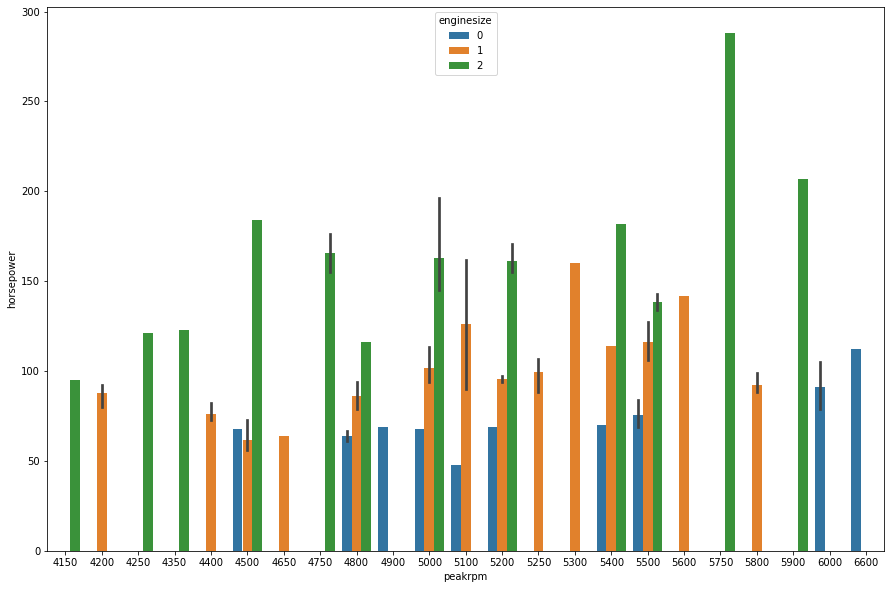

In [22]:
sns.barplot(x='peakrpm', y='horsepower', data=df, hue="enginesize");
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()



С увеличением объема двигателя прослеживается рост мощности двигателя. Скорость вращения двигателя не влият на мощность. Посмотрим на соотношение цены авто и развиваемой им мощности:

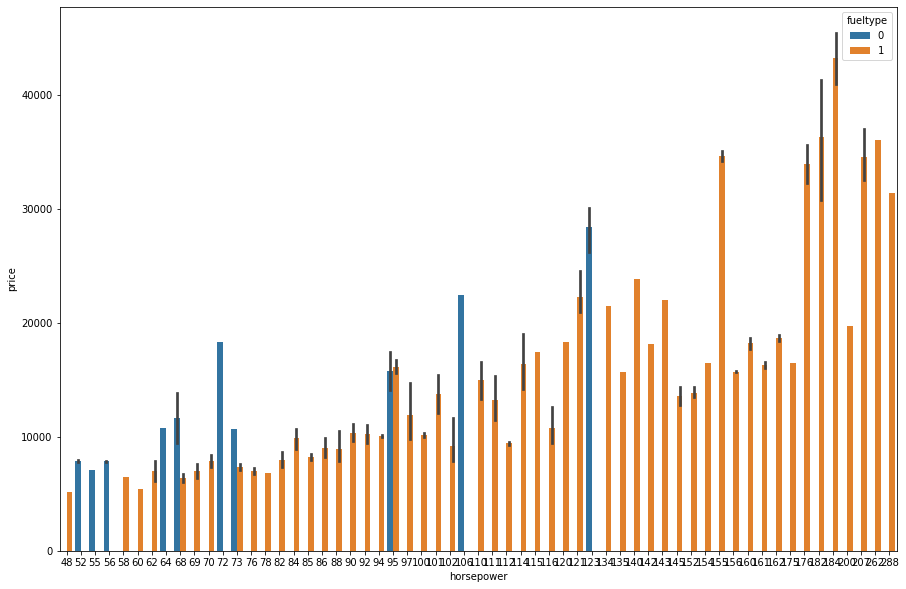

In [23]:
sns.barplot(x='horsepower', y='price', data=df, hue="fueltype");
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()



Чем мощнее авто, тем оно дороже. 

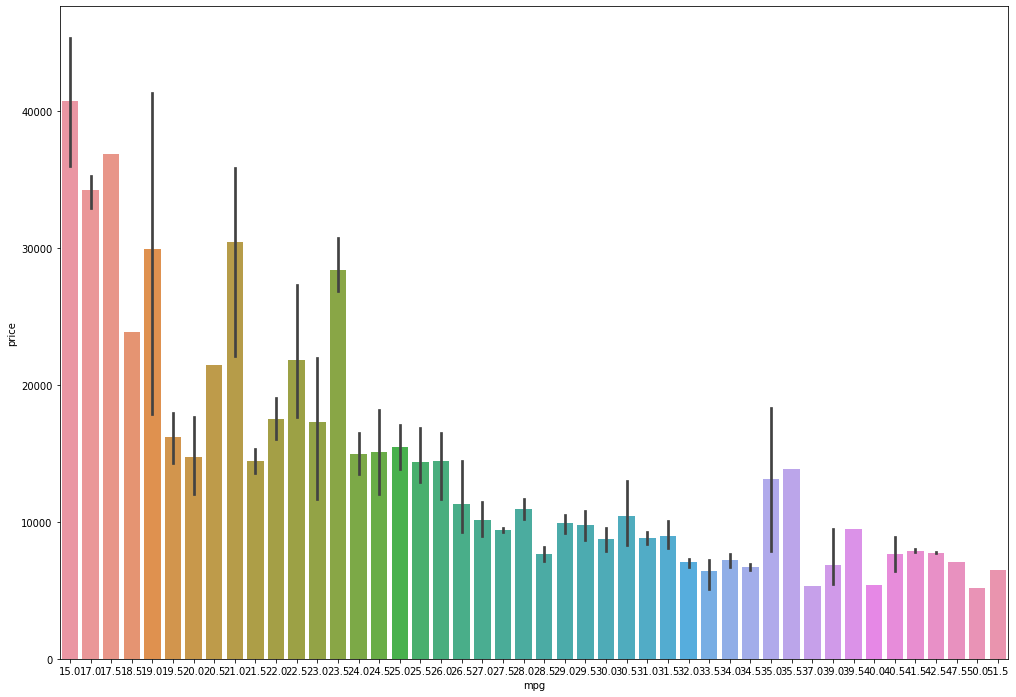

In [24]:
sns.barplot(x='mpg', y='price', data=df);
fig = plt.gcf()
fig.set_size_inches(17, 12)
plt.show()

Экономичные машины - довольно дорогие.

Перейдем к внешним характеристиками автомобилей:

Признак carbody:

In [25]:
df.carbody.unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
      dtype=object)

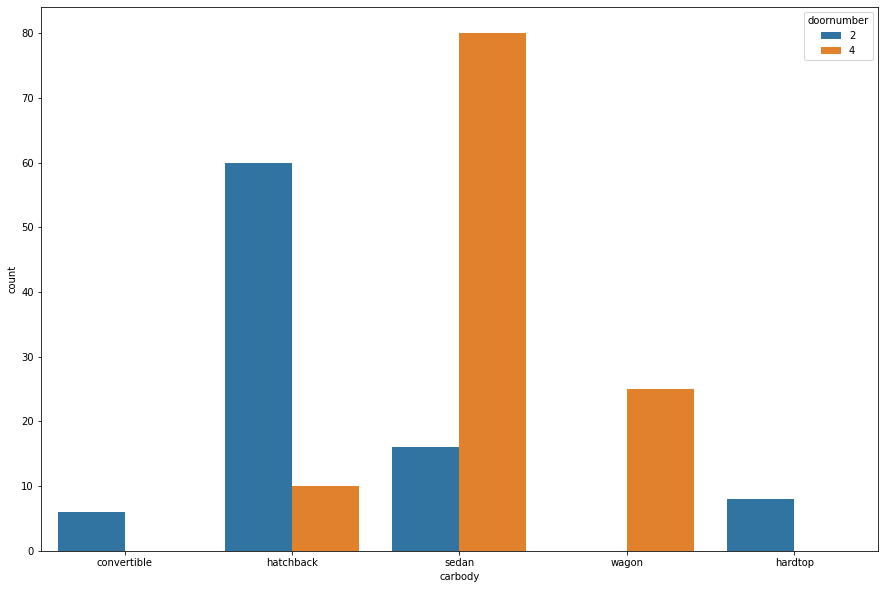

In [26]:
sns.countplot(data=df, x="carbody", hue="doornumber")

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Для простоты будем считать, что авто с 2мя дверями - это купе (coupe)
Но есть, например, hatchback и sedan, у которых есть вариации как с 2мя, так и с 4мя дверями. Удалим такие сущности. 

In [27]:
df.drop(df[df["doornumber"]==4][df["carbody"]=="hatchback"].index, inplace=True)
df.drop(df[df["doornumber"]==2][df["carbody"]=="sedan"].index, inplace=True)

Создадим новый признак coupe:

In [28]:
df["coupe"] = 0
func = lambda doornum: 1 if doornum==2 else 0 
df["coupe"] =  df["doornumber"].apply(func)

Признак enginelocation:

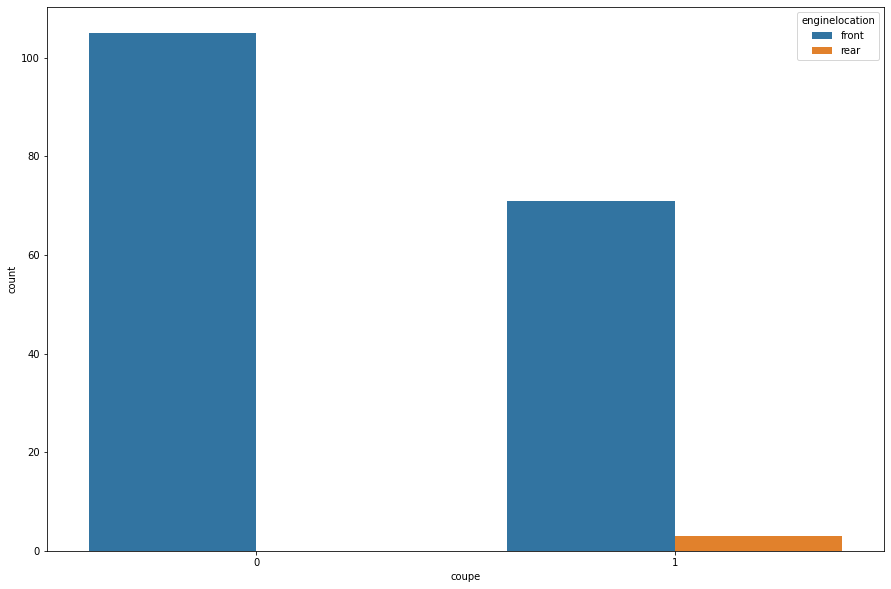

In [29]:
sns.countplot(data=df, x="coupe", hue="enginelocation")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Видно, что с задним расположением двигателя есть авто с кузовом coupe. Их очень мало. как сильно он влияет на цену?

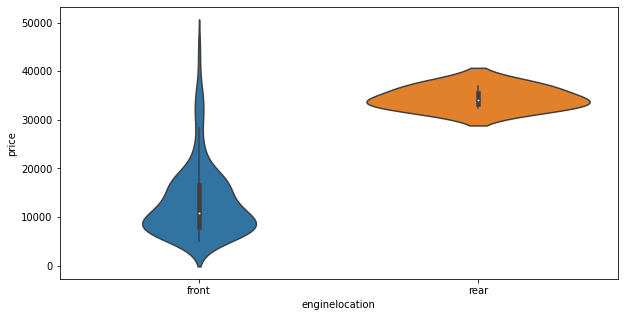

In [30]:
sns.violinplot(data=df, x="enginelocation", y="price")
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Кажется, что расположение двигателя оказывает влияние на цену: авто с задним расположением двигателя оцениваются значительно дороже. Преобразуем этот признак.

In [31]:
df["enginelocation"].replace(["rear", "front"], [1, 0], inplace=True)

Посчитаем объем автомобилей:

In [32]:
df["size"]=0.0
df["size"] = df["carlength"]*df["carwidth"]*df["carheight"]/100000 #посчитаем объем машины

Автомобили обладают разными типами ведущих осей:

In [33]:
df["drivewheel"].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

Посмотрим, как влияет ведущая ось на признак безопасности авто (symboling). Для начала сдвинем значения symboling на -3 и возьмем по модулю для удобства.

In [34]:
df["symboling"].describe()

count    179.000000
mean       0.854749
std        1.294377
min       -2.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: symboling, dtype: float64

In [35]:
from math import fabs
df["symboling"] = df["symboling"].apply(lambda x: fabs(x - 3))
df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,manufacturer,mpg,coupe,size
0,0.0,1,0,2,convertible,rwd,0,88.6,168.8,64.1,...,9.0,111,5000,21,27,13495.0,alfa-romero,24.0,1,5.280199
1,0.0,1,0,2,convertible,rwd,0,88.6,168.8,64.1,...,9.0,111,5000,21,27,16500.0,alfa-romero,24.0,1,5.280199
2,2.0,1,0,2,hatchback,rwd,0,94.5,171.2,65.5,...,9.0,154,5000,19,26,16500.0,alfa-romero,22.5,1,5.875926
3,1.0,1,0,4,sedan,fwd,0,99.8,176.6,66.2,...,10.0,102,5500,24,30,13950.0,audi,27.0,0,6.348170
4,1.0,1,0,4,sedan,4wd,0,99.4,176.6,66.4,...,8.0,115,5500,18,22,17450.0,audi,20.0,0,6.367348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,4.0,1,0,4,sedan,rwd,0,109.1,188.8,68.9,...,9.5,114,5400,23,28,16845.0,volvo,25.5,0,7.219618
201,4.0,1,1,4,sedan,rwd,0,109.1,188.8,68.8,...,8.7,160,5300,19,25,19045.0,volvo,22.0,0,7.209139
202,4.0,1,0,4,sedan,rwd,0,109.1,188.8,68.9,...,8.8,134,5500,18,23,21485.0,volvo,20.5,0,7.219618
203,4.0,0,1,4,sedan,rwd,0,109.1,188.8,68.9,...,23.0,106,4800,26,27,22470.0,volvo,26.5,0,7.219618


Теперь признак имеет следующий характер: 
0 - самый небезопасный
5 - самый безопасный

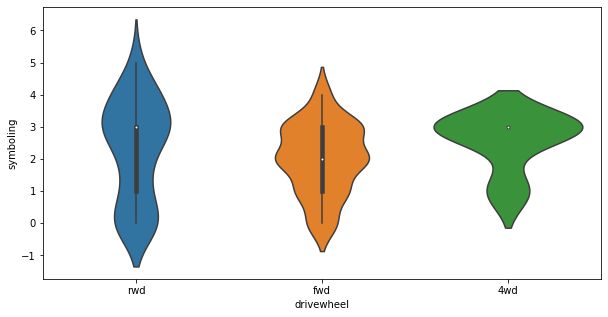

In [36]:
sns.violinplot(x='drivewheel', y='symboling', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

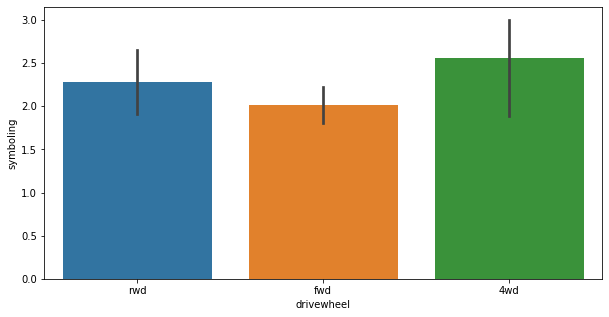

In [37]:
sns.barplot(x='drivewheel', y='symboling', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [38]:
df["drivewheel"].replace(["4wd", "rwd", "fwd"], [3, 2, 1], inplace=True)

Безопаснее всего передвигаться на автомобилях с полным приводом.
Как уровень безопасности влияет на стоимость?

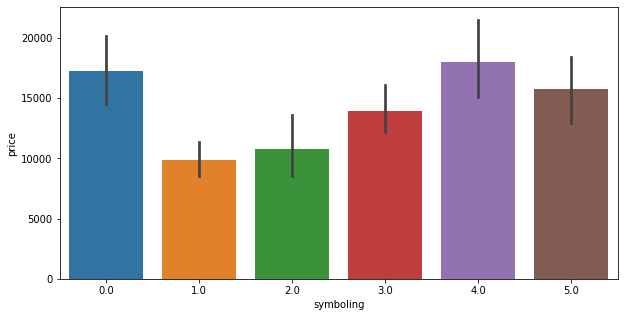

In [39]:
sns.barplot(x='symboling', y='price', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Безопасные авто дороже, но есть исключение: самые небезопасные авто стоят сравнимо в безопасными. С чем это связано?
Сравним мощности авто и категории их безопасности:

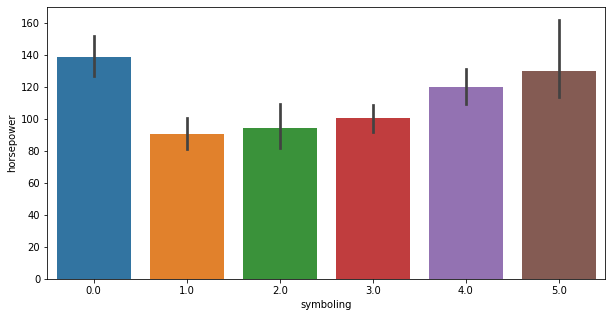

In [40]:
sns.barplot(x='symboling', y='horsepower', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Влияние типа кузова на безопасность:

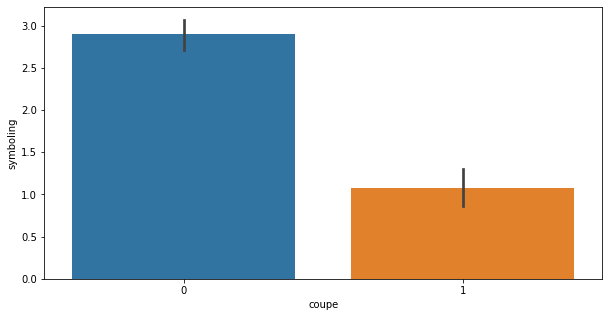

In [41]:
sns.barplot(x='coupe', y='symboling', data=df);
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Влияние размера авто на безопасность:

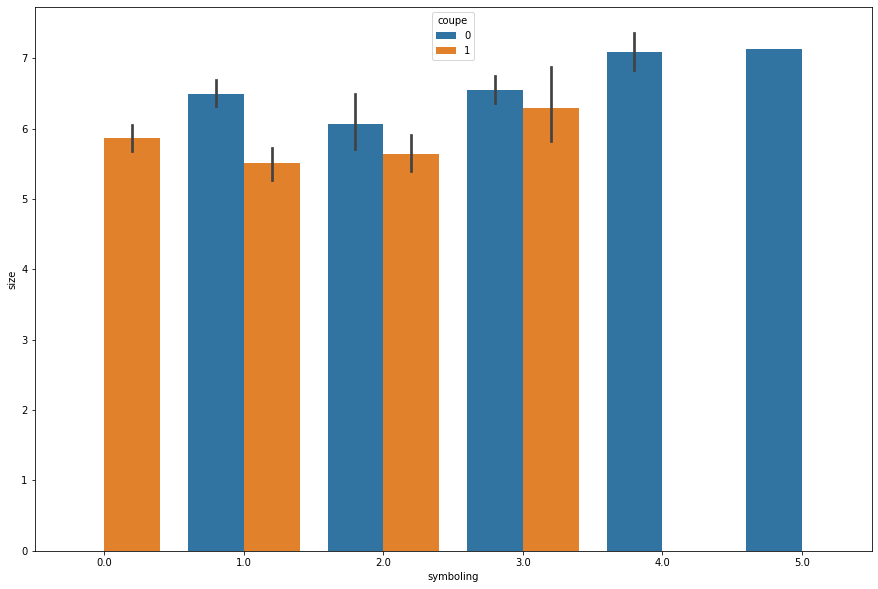

In [42]:
sns.barplot(x='symboling', y='size', data=df, hue="coupe");
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()


Посмотрим зависит ли ценник машины от ее производителя:

In [43]:
df.groupby("manufacturer")["manufacturer"].count()

manufacturer
alfa-romero     3
audi            6
bmw             5
buick           8
chevrolet       3
dodge           7
honda          12
isuzu           3
jaguar          2
maxda           2
mazda          14
mercury         1
mitsubishi     13
nissan         13
peugeot        11
plymouth        6
porcshce        1
porsche         4
renault         2
saab            6
subaru         12
toyota         23
toyouta         1
volkswagen      8
volvo          11
vw              2
Name: manufacturer, dtype: int64

Можно увидеть, что производители машин указаны с опечатками/ошибками, исправим это. Информация из доп. источников утверждает, что vw - это wolkswagen, так и будем считать.

In [44]:
df.replace(["Nissan", "maxda", "porcshce", "toyouta", "vokswagen", "vw"], ["nissan", "mazda", "porsche",  "toyota", "volkswagen", "volkswagen"], inplace=True)
df.groupby("manufacturer")["manufacturer"].count()

manufacturer
alfa-romero     3
audi            6
bmw             5
buick           8
chevrolet       3
dodge           7
honda          12
isuzu           3
jaguar          2
mazda          16
mercury         1
mitsubishi     13
nissan         13
peugeot        11
plymouth        6
porsche         5
renault         2
saab            6
subaru         12
toyota         24
volkswagen     10
volvo          11
Name: manufacturer, dtype: int64

Посмотрим на средний ценник авто каждого производителя

In [45]:
df.groupby("manufacturer")["manufacturer", "price"].mean().sort_values(by="price")

,price
manufacturer,
chevrolet,6007.000000
honda,8004.666667
dodge,8013.142857
plymouth,8252.500000
subaru,8541.250000
isuzu,8916.500000
mitsubishi,9239.769231
renault,9595.000000
toyota,10330.083333


Кажется, что зависит, поэтому назначим порядковые номера

In [46]:
manufactors = list(df.groupby("manufacturer")["manufacturer", "price"].mean().sort_values(by="price").index)
df["manufacturer"] = df["manufacturer"].apply(lambda x: manufactors.index(x))

Подводя итоги, можно сказать, что есть определенные зависимости стоимости автомобиля и мощностью, экономичностью, безопасностью и производителем.

In [47]:
df.drop(["cylindernumber","fueltype",  "aspiration", "curbweight", "compressionratio",    "doornumber", "carbody", "wheelbase", "enginetype", "carlength", "carwidth", "carheight", "fuelsystem", "boreratio", "stroke", "peakrpm", "citympg", "highwaympg"], axis=1, inplace=True)
df

,symboling,drivewheel,enginelocation,enginesize,horsepower,price,manufacturer,mpg,coupe,size
0,0.0,2,0,1,111,13495.0,14,24.0,1,5.280199
1,0.0,2,0,1,111,16500.0,14,24.0,1,5.280199
2,2.0,2,0,2,154,16500.0,14,22.5,1,5.875926
3,1.0,1,0,1,102,13950.0,17,27.0,0,6.348170
4,1.0,3,0,1,115,17450.0,17,20.0,0,6.367348
...,...,...,...,...,...,...,...,...,...,...
200,4.0,2,0,1,114,16845.0,16,25.5,0,7.219618
201,4.0,2,0,1,160,19045.0,16,22.0,0,7.209139
202,4.0,2,0,2,134,21485.0,16,20.5,0,7.219618
203,4.0,2,0,1,106,22470.0,16,26.5,0,7.219618


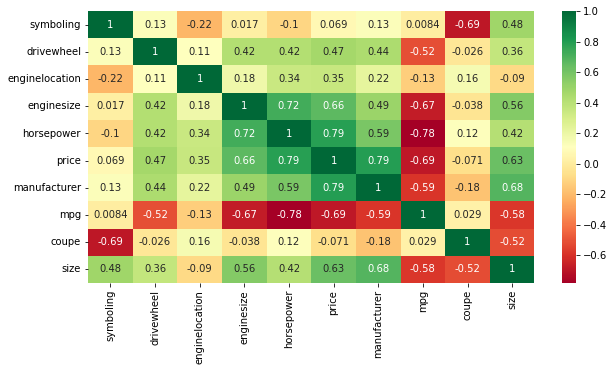

In [48]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Случайно разделим данные на тренировочную и тестовую выборки

In [49]:
y = df["price"]
X = df.drop(["price"], axis=1)


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Масштабируем данные:

In [51]:
from sklearn.preprocessing import StandardScaler

numeric_features = ["symboling", "drivewheel", "enginesize", "horsepower", "manufacturer", "mpg", "size"]
binary_features = ["enginelocation", "coupe"]

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train = np.c_[X_train_scaled, np.array(X_train[binary_features])]
X_test = np.c_[X_test_scaled, np.array(X_test[binary_features])]

# Логорифмируем таргет
y_train = np.array(np.log(y_train))
y_test = np.array(np.log(y_test))

Реализуем метод gradient_descent


In [52]:
from math import sqrt
def MSE(y, w, x):
    return 1/len(y)*sum(list(map(lambda x: (x[0] - x[1])**2,  zip(y, w.dot(x.T)))))

def L2(w):
    w_ = w[:-1]
    return w_.T.dot(w_)
def grad_L2(w):
    return np.array([2*x for x in w[:-1]] + [0.0])
    
def grad_MSE(y, w, x):
    prediction = w.dot(x.T)
    return -2/len(y)*x.T.dot(y - prediction)

def MSE_L2_grad(y, w, x, alph = 1):
    return grad_MSE(y, w, x)+alph*grad_L2(w)

def gradient_descent(x, y, eps=0.1**3, w=None):
    #Adding bias 
    x_bias = np.c_[x, np.ones(len(x))]
    if (w is None):
        w = np.ones(x_bias.shape[1])
        
    w_pred = np.zeros(x_bias.shape[1]);
    i=0
    while (sqrt((w - w_pred).T.dot(w - w_pred)) > eps):
        grad = MSE_L2_grad(y, w, x_bias)
        #grad = grad_MSE(y, w, x_bias)
        w_pred = w
        w = w -  1/(i+1)*grad
        i+=1
    return np.array(w)

def predict(w: np.array, x):
    x_bias = np.c_[x, np.ones(len(x))]
    return np.array(w.dot(x_bias.T))


Обучим модели

In [53]:
weights = gradient_descent(X_train, y_train);#

y_train_my_pred = predict( weights, X_train);#
y_test_my_pred = predict(weights, X_test);#


In [54]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

model = Ridge()  # выбранная модель

model.fit(X_train, y_train)  # обучение модели на обучающей выборке

y_train_Ridge_pred = model.predict(X_train)  # использование модели для предсказания на обучающей
y_test_Ridge_pred = model.predict(X_test)  # или на тестовой выборке


In [55]:
RMSE_test_Ridge = mean_squared_error(y_test, y_test_Ridge_pred, squared=False)
MSE_test_Ridge = mean_squared_error(y_test, y_test_Ridge_pred, squared=True)
R2_test_Ridge = r2_score(y_test, y_test_Ridge_pred)

RMSE_train_Ridge = mean_squared_error(y_train, y_train_Ridge_pred, squared=False)
MSE_train_Ridge = mean_squared_error(y_train, y_train_Ridge_pred, squared=True)
R2_train_Ridge = r2_score(y_train, y_train_Ridge_pred)

RMSE_test_my = mean_squared_error(y_test, y_test_my_pred, squared=False)
MSE_test_my = mean_squared_error(y_test, y_test_my_pred, squared=True)
R2_test_my = r2_score(y_test, y_test_my_pred)

RMSE_train_my = mean_squared_error(y_train, y_train_my_pred, squared=False)
MSE_train_my = mean_squared_error(y_train, y_train_my_pred, squared=True)
R2_train_my = r2_score(y_train, y_train_my_pred)
table = {
    "": ["Mine_train", "Mine_test", "Ridge_train", "Ridge_test"],
    "MSE" : [MSE_train_my, MSE_test_my, MSE_train_Ridge, MSE_test_Ridge],
    "RMSE" : [RMSE_train_my, RMSE_test_my, RMSE_train_Ridge, RMSE_test_Ridge],
    "R2" : [R2_train_my, R2_test_my, R2_train_Ridge, R2_test_Ridge ] 
    
}
print("Сравнительная таблица оценок реализованного метода gradient descent и модели Ridge")
print(pd.DataFrame(data = table))

Сравнительная таблица оценок реализованного метода gradient descent и модели Ridge
                     MSE      RMSE        R2
0   Mine_train  0.044521  0.210999  0.828227
1    Mine_test  0.031478  0.177420  0.844266
2  Ridge_train  0.029550  0.171900  0.885988
3   Ridge_test  0.029465  0.171653  0.854227


Сравнивая MSE и RMSE у обученных моделей, можно сделать вывод, что модель Ridge дает несколько лучшие результаты.
R2 оценка у обоих моделей близка 1, что говорит о том, что модели в некотором смысле хорошо описывают данные. Однако, Ridge удалось выявить зависимости лучше.

Выполним кросс-валидацию

In [56]:


# масштабируем данные и запоминаем среднее, стандартное отклонение признаков
X_scaled = scaler.fit_transform(X[numeric_features])
X = np.c_[X_scaled, np.array(X[binary_features])]

# Логорифмируем таргет
y = np.array(np.log(y))

def get_folds(X, y, foldsnum):
    res = {"data": [],
           "target": [],
           "len": foldsnum
          }
    count = 0
    foldlen = int(len(X)/foldsnum)
    for i in range(1, foldsnum+1): 
        kcount = foldlen*i
        res["data"].append(X[count:kcount])
        res["target"].append(y[count:kcount])
        count = kcount        
    return res

folds = get_folds(X, y, 5);
MSE_Ridge = {
    "train": [],
    "test": []
}
MSE_my = {
    "train": [],
    "test": []
}

RMSE_Ridge = {
    "train":[],
    "test": []
}
RMSE_my = {
    "train":[],
    "test": []
}

R2_my = {
    "train":[],
    "test": []
}

R2_Ridge = {
    "train":[],
    "test": []
}



for i in  range(folds["len"]):
    model = Ridge();
    data = np.empty(shape=X.shape)
    targ = np.empty(shape=y.shape)
    we = None;
    for k in range(folds["len"]):
        if (i == k):
            continue;
        model.fit(folds["data"][k], folds["target"][k])
        we = gradient_descent(folds["data"][k], folds["target"][k], w=we)
        data = np.r_[data, folds["data"][k]]
        targ = np.r_[targ, folds["target"][k]]
    ridge_test = model.predict(folds["data"][i])
    my_test = predict(we, folds["data"][i])
    ridge_train = model.predict(data)
    my_train = predict(we, data)
    
    MSE_Ridge["train"].append(mean_squared_error(targ, ridge_train, squared=True))
    MSE_my["train"].append(mean_squared_error(targ, my_train, squared=True))
    MSE_Ridge["test"].append(mean_squared_error(folds["target"][i], ridge_test, squared=True))
    MSE_my["test"].append(mean_squared_error(folds["target"][i], my_test, squared=True))
    
    RMSE_Ridge["train"].append(mean_squared_error(targ, ridge_train, squared=False))
    RMSE_my["train"].append(mean_squared_error(targ, my_train, squared=False))
    RMSE_Ridge["test"].append(mean_squared_error(folds["target"][i], ridge_test, squared=False))
    RMSE_my["test"].append(mean_squared_error(folds["target"][i], my_test, squared=False))
    
    R2_Ridge["train"].append(r2_score(targ, ridge_train))
    R2_my["train"].append(r2_score(targ, my_train))
    R2_Ridge["test"].append(r2_score(folds["target"][i], ridge_test))
    R2_my["test"].append(r2_score(folds["target"][i], my_test))



In [57]:
table = {
    "": ["MSE_train", "MSE_test", "RMSE_train", "RMSE_test", "R2_train", "R2_test"],
    "Fold1": [MSE_my["train"][0], MSE_my["test"][0], RMSE_my["train"][0], RMSE_my["test"][0], R2_my["train"][0], R2_my["test"][0]],
    "Fold2": [MSE_my["train"][1], MSE_my["test"][1], RMSE_my["train"][1], RMSE_my["test"][1], R2_my["train"][1], R2_my["test"][1]],
    "Fold3": [MSE_my["train"][2], MSE_my["test"][2], RMSE_my["train"][2], RMSE_my["test"][2], R2_my["train"][2], R2_my["test"][2]],
    "Fold4": [MSE_my["train"][3], MSE_my["test"][3], RMSE_my["train"][3], RMSE_my["test"][3], R2_my["train"][3], R2_my["test"][3]],
    "Fold5": [MSE_my["train"][4], MSE_my["test"][4], RMSE_my["train"][4], RMSE_my["test"][4], R2_my["train"][4], R2_my["test"][4]],
    "STD":   [np.std(MSE_my["train"]), np.std(MSE_my["test"]), np.std(RMSE_my["train"]), np.std(RMSE_my["test"]), np.std(R2_my["train"]), np.std(R2_my["test"])],
    "E": [np.mean(MSE_my["train"]), np.mean(MSE_my["test"]), np.mean(RMSE_my["train"]), np.mean(RMSE_my["test"]), np.mean(R2_my["train"]), np.mean(R2_my["test"])],
    

}
print("Таблица кросс-валидации для реализованного метода gradient_descent")
print(pd.DataFrame(data=table))


table = {
    "": ["MSE_train", "MSE_test", "RMSE_train", "RMSE_test", "R2_train", "R2_test"],
    "Fold1": [MSE_Ridge["train"][0], MSE_Ridge["test"][0], RMSE_Ridge["train"][0], RMSE_Ridge["test"][0], R2_Ridge["train"][0], R2_Ridge["test"][0]],
    "Fold2": [MSE_Ridge["train"][1], MSE_Ridge["test"][1], RMSE_Ridge["train"][1], RMSE_Ridge["test"][1], R2_Ridge["train"][1], R2_Ridge["test"][1]],
    "Fold3": [MSE_Ridge["train"][2], MSE_Ridge["test"][2], RMSE_Ridge["train"][2], RMSE_Ridge["test"][2], R2_Ridge["train"][2], R2_Ridge["test"][2]],
    "Fold4": [MSE_Ridge["train"][3], MSE_Ridge["test"][3], RMSE_Ridge["train"][3], RMSE_Ridge["test"][3], R2_Ridge["train"][3], R2_Ridge["test"][3]],
    "Fold5": [MSE_Ridge["train"][4], MSE_Ridge["test"][4], RMSE_Ridge["train"][4], RMSE_Ridge["test"][4], R2_Ridge["train"][4], R2_Ridge["test"][4]],
    "STD":   [np.std(MSE_Ridge["train"]), np.std(MSE_Ridge["test"]), np.std(RMSE_Ridge["train"]), np.std(RMSE_Ridge["test"]), np.std(R2_Ridge["train"]), np.std(R2_Ridge["test"])],
    "E": [np.mean(MSE_Ridge["train"]), np.mean(MSE_Ridge["test"]), np.mean(RMSE_Ridge["train"]), np.mean(RMSE_Ridge["test"]), np.mean(R2_Ridge["train"]), np.mean(R2_Ridge["test"])],
}

print("\n\n\nТаблица кросс-валидации для модели Ridge")
print(pd.DataFrame(data=table))

Таблица кросс-валидации для реализованного метода gradient_descent
                  Fold1      Fold2      Fold3      Fold4      Fold5       STD  \
0   MSE_train       inf  49.078257  49.260975  49.191987  48.882054       NaN   
1    MSE_test  0.104047   0.212761   0.048423   0.155833   0.041815  0.064967   
2  RMSE_train       inf   7.005588   7.018616   7.013700   6.991570       NaN   
3   RMSE_test  0.322563   0.461260   0.220052   0.394757   0.204488  0.098874   
4    R2_train      -inf  -1.281544  -1.267685  -1.259300  -1.250468       NaN   
5     R2_test  0.644479   0.506831   0.610219   0.437355   0.456812  0.082475   

          E  
0       inf  
1  0.112576  
2       inf  
3  0.320624  
4      -inf  
5  0.531139  



Таблица кросс-валидации для модели Ridge
                  Fold1      Fold2      Fold3      Fold4      Fold5       STD  \
0   MSE_train       inf  48.620738  48.987038  48.853706  49.484698       NaN   
1    MSE_test  0.067900   0.127251   0.032238   0.102869   0.

При кросс-валидации наблюдаются похожие результаты: модель Ridge дает более точные предсказания и лучше описывает результаты. При кросс-валидации реализованная модель сильнее проигрывает Ridge в точности предсказаний.

In [58]:
[np.mean(MSE_Ridge["train"]), np.mean(MSE_Ridge["test"]), np.mean(RMSE_Ridge["train"]), np.mean(RMSE_Ridge["test"]), np.mean(R2_Ridge["train"]), np.mean(R2_Ridge["test"])],

([inf, 0.0743, inf, 0.2640, -inf, 0.6619],)